In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# SVD 학습
- numpy svd를 활용해 직접 `행렬 분해`를 구현
- `SVD`를 수행하기 위해선 `Rating Matrix`가 모두 채워져 있어야 합니다 $\to$ `Dense Matrix`
    - user average / item average로 채움
- `Latent Factor` 개수에 따라 달라지는 `rmse` 값을 확인합니다.

In [1]:
import os
import pandas as pd
import seaborn as sns
import scipy
import numpy as np
import random
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

In [5]:
path = '/content/drive/MyDrive/Colab_Notebook/learning_spoons_recommendation_system/data/ml-latest-small/'

In [7]:
ratings_df = pd.read_csv(path + 'ratings.csv', encoding='utf-8')
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


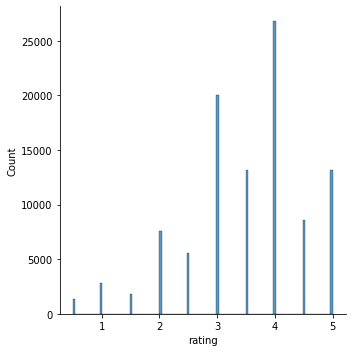

In [8]:
sns.displot(ratings_df['rating'])

## numpy로 직접 SVD 구현

In [10]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=10)

print('train_df :', train_df.shape, ', test_df :', test_df.shape)

train_df : (80668, 4) , test_df : (20168, 4)


In [11]:
user_item_matrix = train_df.pivot_table('rating', 'userId', 'movieId')

- `SVD`를 수행하기 위해서는 빈 entry가 없는 `Dense Matrix`가 되어야 합니다
- 행렬이 비어있는 entry에 유저 혹은 아이템 기준으로 구한 평균 평점을 채워넣습니다

In [12]:
user_item_matrix

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185029,185031,185033,185135,185435,185473,185585,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,4.5,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,NaN,NaN,2.0,NaN,3.5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# 평균 평점으로 채워 넣음 - 유저 평균 평점
user_item_matrix = user_item_matrix.apply(lambda x: x.fillna(x.mean()), axis=1) # axis=0 : index 기준(행), axis=1 : 열 기준(열)

# 평균 평점으로 채워 넣음 - 영화 평균 평점
# user_item_matrix = user_item_matrix.apply(lambda x: x.fillna(x.mean()), axis=0)

In [14]:
user_item_matrix

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185029,185031,185033,185135,185435,185473,185585,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.000000,4.372973,4.000000,4.372973,4.372973,4.000000,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,...,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973
2,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,...,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333
3,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,...,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517
4,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.000000,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,2.000000,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,...,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989
5,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,4.000000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,4.000000,3.500000,3.500000,3.000000,3.500000,3.500000,3.500000,3.500000,...,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500

- numpy에서 제공하는 [SVD](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html)

In [21]:
def calculate_SVD(matrix, k=20):
    # numpy SVD 수행
    u, sig, i = np.linalg.svd(matrix)

    # 유저 매트릭스 가운데 k개 latent factor만 사용
    # u.shape = (610, 610)
    u_hat = u[:, :k]

    # 아이템 매트릭스 가운데 k개 latne factor만 사용
    # i.shape = (9001, 9001)
    i_hat = i[:k, :]

    # 잠재 요인 대각 행렬
    # sig : matrix의 singular value, 가장 큰 값부터 내림차순으로 정렬되어 있음
    # lenght(sig) = min(610, 9001) = 610
    sig_hat = sig[:k] * np.identity(k, np.float) # 행렬 값 float화

    user_factors = u_hat
    item_factors = np.matmul(sig_hat, i_hat)
    
    return user_factors, item_factors


In [22]:
# 예제
k = 50
user_factors, item_factors = calculate_SVD(user_item_matrix, 50)

In [23]:
# 유저 잠재 요인, 아이템 잠재 요인 행렬
print('user_factors :', user_factors.shape, ', item_factors :', item_factors.shape)

user_factors : (610, 50) , item_factors : (50, 9001)


- 두 잠재 요인 행렬을 곱하면 유저-아이템 조합에 대한 예측 평점의 행렬을 구할 수 있습니다


In [24]:
prediction_result_df = pd.DataFrame(np.matmul(user_factors, item_factors),
                                    columns=user_item_matrix.columns.values, index=user_item_matrix.index.values)

In [25]:
# train 데이터로 만든 평점 예측 값 R_hat
prediction_result_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185029,185031,185033,185135,185435,185473,185585,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193587,193609
1,4.455760,4.376862,4.445517,4.378512,4.336953,4.230930,4.287235,4.378368,4.379953,4.338540,4.331611,4.377108,4.391719,4.359317,4.363184,4.390866,4.279915,4.387565,4.493591,4.362606,4.427732,4.352392,4.352214,4.302841,4.390785,4.368228,4.374986,4.390186,4.432690,4.364689,4.325035,4.347326,4.321318,4.370756,4.377355,4.296145,4.377229,4.366598,4.370298,4.377639,...,4.370170,4.373932,4.363878,4.375277,4.379778,4.370569,4.370360,4.372861,4.374903,4.370288,4.366956,4.356516,4.361863,4.372243,4.373351,4.376301,4.377261,4.373562,4.371744,4.372760,4.374794,4.338507,4.383248,4.371949,4.377198,4.368109,4.379016,4.377198,4.379016,4.379016,4.374534,4.372675,4.371745,4.373604,4.373604,4.372675,4.373604,4.372675,4.372675,4.373269
2,4.116021,4.093123,4.059365,4.075956,4.089813,4.076023,4.054649,4.081869,4.076706,4.093391,4.063080,4.057914,4.085746,4.079204,4.087732,4.066698,4.082231,4.089004,4.063108,4.070472,4.095819,4.073407,4.101016,4.072113,4.058665,4.080043,4.092581,4.096768,4.103887,4.082954,4.104497,4.057154,4.090061,4.095299,4.086751,4.067778,4.087748,4.086052,4.088641,4.082660,...,4.079655,4.083995,4.077426,4.083648,4.085767,4.081763,4.084692,4.083186,4.077055,4.081231,4.081570,4.082462,4.082742,4.084974,4.082945,4.085505,4.086100,4.083392,4.083178,4.083518,4.081489,4.072165,4.083860,4.084450,4.083820,4.082750,4.084034,4.083820,4.084034,4.084034,4.085951,4.082815,4.081246,4.084383,4.084383,4.082815,4.084383,4.082815,4.082815,4.083071
3,2.489142,2.493289,2.435234,2.471230,2.497086,2.406091,2.466641,2.491103,2.462545,2.481086,2.416361,2.438978,2.468215,2.450856,2.463744,2.433893,2.380089,2.446880,2.553131,2.480213,2.489118,2.457557,2.475471,2.432137,2.400360,2.458727,2.465684,2.471599,2.476933,2.465910,2.498992,2.474013,2.432515,2.467952,2.461193,2.466317,2.469526,2.454159,2.476139,2.472736,...,2.457685,2.465594,2.469113,2.465262,2.468406,2.466473,2.465720,2.465414,2.462471,2.455330,2.470476,2.481939,2.476607,2.470383,2.464902,2.466741,2.463833,2.465740,2.465068,2.465819,2.462511,2.451237,2.455278,2.466249,2.467083,2.463725,2.467754,2.467083,2.467754,2.467754,2.467970,2.465050,2.463590,2.466510,2.466510,2.465050,2.466510,2.465050,2.465050,2.465735
4,3.438885,3.538087,3.404722,3.516883,3.387723,3.323818,3.443567,3.498151,3.554042,3.884841,3.490976,3.537177,3.513757,3.466556,3.522172,3.631705,3.243450,3.541738,3.729583,3.477464,3.511713,3.521525,3.499961,3.207151,3.299429,3.526328,3.525252,3.580570,3.629229,3.510448,3.551675,1.819395,3.630472,3.549422,3.520846,3.355189,3.547600,3.552538,3.512105,3.554307,...,3.608797,3.524106,3.466103,3.518447,3.486472,3.507961,3.523687,3.522839,3.554297,3.599893,3.505967,3.581651,3.562605,3.519763,3.528774,3.534232,3.549820,3.525300,3.518221,3.522306,3.550938,3.393236,3.486424,3.511095,3.539460,3.504062,3.546539,3.539460,3.546539,3.546539,3.524558,3.522719,3.521799,3.523639,3.523639,3.522719,3.523639,3.522719,3.522719,3.526527
5,3.535751,3.476395,3.438381,3.478689,3.454173,3.565401,3.468226,3.491675,3.488108,3.454820,3.532224,3.474371,3.478311,3.510593,3.511035,3.528704,3.564892,3.520706,3.332264,3.474704,3.495521,3.499043,3.504074,3.477149,3.535109,3.502888,3.496196,3.513305,3.504408,3.505034,3.487960,3.627316,3.579008,3.525669,3.489152,3.436737,3.502242,3.516628,3.490955,3.489021,...,3.497125,3.500381,3.491485,3.500187,3.498734,3.497747,3.500562,3.499919,3.489765,3.504137,3.498526,3.489372,3.492824,3.500510,3.498800,3.502180,3.504010,3.499468,3.501117,3.499799,3.494180,3.509335,3.506633,3.502756,3.496169,3.504415,3.494520,3.496169,3.494520,3.494520,3.500828,3.499840,3.499346,3.500334,3.500334,3.499840,3.500334,3

- 다음은 예측 평점을 사용해서 test 데이터를 예측해봅니다

In [27]:
# test 데이터에 새로 등장하는 유저, 아이템을 위한 global rating
global_rating = train_df['rating'].mean()

In [31]:
result = []

for _, row in tqdm(test_df.iterrows()):
    # 예측해야하는 유저, 아이템, 평점
    user_id = row['userId']
    movie_id = row['movieId']
    true_rating = row['rating']

    if user_id in prediction_result_df.index.values and movie_id in prediction_result_df.columns.values:
        pred_rating = prediction_result_df.loc[user_id][movie_id]
    else:
        pred_rating = global_rating
    
    result.append([user_id, movie_id, true_rating, pred_rating])

result_df = pd.DataFrame(result, columns=['user_id', 'movie_id', 'true_rating', 'pred_rating'])

20168it [00:04, 4488.95it/s]


In [32]:
result_df

,user_id,movie_id,true_rating,pred_rating
0,239.0,924.0,4.0,4.106564
1,384.0,2763.0,3.0,2.957313
2,52.0,58559.0,5.0,4.640744
3,600.0,719.0,2.5,3.038116
4,318.0,117364.0,4.0,3.503954
...,...,...,...,...
20163,20.0,5015.0,4.0,3.472314
20164,177.0,6787.0,3.0,3.400911
20165,103.0,969.0,4.0,3.926839
20166,42.0,2875.0,3.0,3.609600


In [34]:
print('RMSE :', np.sqrt(mean_squared_error(result_df['true_rating'].values, result_df['pred_rating'].values)))

RMSE : 0.9342638634779828


- 오차 값이 1에 가까우므로 정확도가 높다고 할 수 없습니다

## SVD의 적합한 k 찾기
- `SVD`를 수행할 때 사용하는 잠재요인의 숫자는 사용자가 정하는 하이퍼 파라미터입니다
- `k`에 따라 학습 성능과 예측 성능이 얼마나 달라지는지 실험해 봅니다

In [35]:
# 사용자 평균 평점으로 빈 entry를 채움
user_item_matrix = train_df.pivot_table('rating', 'userId', 'movieId')
user_item_matrix = user_item_matrix.apply(lambda x: x.fillna(x.mean()), axis=1)

In [36]:
global_rating = train_df['rating'].mean()

In [38]:
train_result, test_result = [], []

# k에 따라서 모델을 학습하고 평가함
for k in tqdm(np.arange(2, 20, 2)):
    # 모델 학습 및 평균 추론
    user_factors, item_factors = calculate_SVD(user_item_matrix, k)
    prediction_result_df = pd.DataFrame(np.matmul(user_factors, item_factors),
                                        columns=user_item_matrix.columns.values, index=user_item_matrix.index.values)

    # 학습 데이터 평가
    pred_rating, true_rating = [], []
    for _, row in train_df.iterrows():
        user_id = row['userId']
        movie_id = row['movieId']
        true_rating.append(row['rating'])

        if user_id in user_item_matrix.index.values and movie_id in user_item_matrix.columns.values:
            pred_rating.append(prediction_result_df.loc[user_id][movie_id])
        else:
            pred_rating.append(global_rating)

    rmse = np.sqrt(mean_squared_error(np.asarray(true_rating), np.asarray(pred_rating)))
    train_result.append([k, rmse])

    # 테스트 데이터 평가
    pred_rating, true_rating = [], []
    for _, row in test_df.iterrows():
        user_id = row['userId']
        movie_id = row['movieId']
        true_rating.append(row['rating'])

        if user_id in user_item_matrix.index.values and movie_id in user_item_matrix.columns.values:
            pred_rating.append(prediction_result_df.loc[user_id][movie_id])
        else:
            pred_rating.append(global_rating)

    rmse = np.sqrt(mean_squared_error(np.asarray(true_rating), np.asarray(pred_rating)))
    test_result.append([k, rmse])

k_train_result_df = pd.DataFrame(train_result, columns=['k', 'rmse'])
k_test_result_df = pd.DataFrame(test_result, columns=['k', 'rmse'])


100%|██████████| 9/9 [06:02<00:00, 40.26s/it]


- `train` 데이터와 `test` 데이터 평가표를 작성합니다

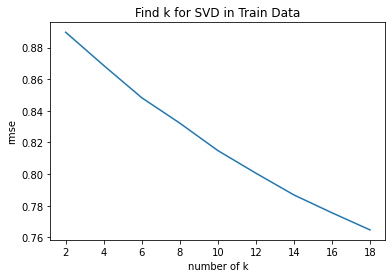

In [41]:
plt.plot(k_train_result_df.k, k_train_result_df.rmse)
plt.title('Find k for SVD in Train Data')
plt.xlabel('number of k', fontsize=10)
plt.ylabel('rmse')
plt.show()

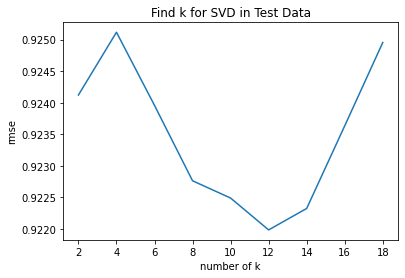

In [43]:
plt.plot(k_test_result_df.k, k_test_result_df.rmse)
plt.title('Find k for SVD in Test Data')
plt.xlabel('number of k', fontsize=10)
plt.ylabel('rmse')
plt.show()

- `train` 데이터를 보면 `k`가 증가할 수록 점점 오차가 줄어드는 것을 확인(이후 증가할 수록 오차가 줄어드는 것까진...)
- 학습한 모델을 기반으로 `test` 데이터에 적용해본 결과 `k` = 12 일때가 가장 오차가 적음을 확인할 수 있습니다